**Due date**: midnight Sunday 19 March (end Week 10).

**Weighting**: 20% of the module.

In this assignment the goal is to take advantage of pre-trained NN models to create an embedding with a dataset of movie posters, and demonstrate how to use that embedding.

The dataset is provided, along with some skeleton code for loading it.

The individual steps to be carried out are specified below, with `### YOUR CODE HERE` markers, together with the number of marks available for each part.

* **Topics**: in Part 5 below, students are asked to add some improvement to their models. In general, these improvements will differ between students (or student groups). **The proposed improvement must be notified to the lecturer at least 1 week before submission, and approved by the lecturer**. If working in a group, the two members of the group should not work on different topics in Part 5: they must work on the same topic and submit identical submissions.

* Students are not required to work incrementally on the parts. It is ok to do all the work in one day, so long as you abide by the rules on notifying groups and notifying topics.

* **Groups**: students may work solo or in a group of two. A student may not work together in a group with any student they have previously worked on a group project with, in this module or any other in the MSc programme. **Groups must be notified to the lecturer in writing before beginning work and at least 1 week before submission.** If working in a group, both students must submit and both submissions must be identical. If working in a group, both students may be asked to explain any aspect of the code in interview (see below), therefore working independently on separate components is not recommended. Any emails concerning the project should be cc-ed to the other group member.

* **Libraries**: code can be written in Keras/Tensorflow, or in PyTorch. 

* **Plagiarism**: students may discuss the assignment together, but you may not look at another student or group's work or allow other students to view yours (other than within a group). You may use snippets of code (eg 1-2 lines) from the internet, **if you provide a citation with URL**. You may also use a longer snippet of code if it is a utility function, again only with citation. You may not use code from the internet to carry out the core of the assignment. You may not use a large language model to generate code.

* **Submission**: after completing your work in this Jupyter notebook, submit the notebook both in `.ipynb` and `.pdf` formats. The content should be identical.

* **Interviews**: a number of students may be selected for interview, post-submission. The selection will depend on submissions, and random chance may be used also. Interviews will be held in-person (CT5133) or online (CT5145). Interviews will last approximately 10 minutes. The purpose of interviews will be to assess students' understanding of their own submission.


### Dataset Credits

The original csv file is from: 

https://www.kaggle.com/datasets/neha1703/movie-genre-from-its-poster

I have added the *year* column for convenience.

I believe most of the information is originally from the famous MovieLens dataset:

* https://grouplens.org/datasets/movielens/
* https://movielens.org/

However, I'm not clear whether the poster download URLs (Amazon AWS URLs) which are in the csv obtained from the Kaggle URL above are from a MovieLens source, or elsewhere.

To create the dataset we are using, I have randomly sampled a small proportion of the URLs in the csv, and downloaded the images. I have removed those which fail to download. Code below also filters out those which are in black and white, ie 1 channel only.

### Imports

You can add more imports if needed.

In [181]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist, pdist, squareform # useful for distances in the embedding

In [182]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models

### Utility functions

These functions are provided to save you time. You might not need to understand any of the details here.

In [183]:
# walk the directory containing posters and read them in. all are the same shape: (268, 182).
# all have 3 channels, with a few exceptions (see below).
# each is named <imdbId>.jpg, which will later allow us to get the metadata from the csv.
IDs = []
images = []
for dirname, _, filenames in os.walk('/Users/apple/Downloads/Assignment_2/DL_Sample'):
    for filename in filenames:
        if filename.endswith(".jpg"):
            ID = int(filename[:-4])
            pathname = os.path.join(dirname, filename)
            im = Image.open(pathname)
            imnp = np.array(im, dtype=float)
            if len(imnp.shape) != 3: # we'll ignore a few black-and-white (1 channel) images
                print("This is 1 channel, so we omit it", imnp.shape, filename)
                continue # do not add to our list
            IDs.append(ID)
            images.append(imnp)

In [184]:
img_array = np.array(images)

In [185]:
img_array.shape

(1238, 268, 182, 3)

In [186]:
# read the csv
df = pd.read_csv("/Users/apple/Downloads/Assignment_2/Movie_Genre_Year_Poster.csv", encoding="ISO-8859-1", index_col="Unnamed: 0")
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Genre,Poster,Year
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation|Adventure|Comedy,https://images-na.ssl-images-amazon.com/images...,1995.0
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action|Adventure|Family,https://images-na.ssl-images-amazon.com/images...,1995.0
2,113228,http://www.imdb.com/title/tt113228,Grumpier Old Men (1995),6.6,Comedy|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
3,114885,http://www.imdb.com/title/tt114885,Waiting to Exhale (1995),5.7,Comedy|Drama|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0
4,113041,http://www.imdb.com/title/tt113041,Father of the Bride Part II (1995),5.9,Comedy|Family|Romance,https://images-na.ssl-images-amazon.com/images...,1995.0


In [187]:
df2 = df.drop_duplicates(subset=["imdbId"]) # some imdbId values are duplicates - just drop

In [188]:
df3 = df2.set_index("imdbId") # the imdbId is a more useful index, eg as in the next cell...

In [189]:
df4 = df3.loc[IDs] # ... we can now use .loc to take a subset

In [190]:
df4.shape # 1238 rows matches the image data shape above

(1238, 6)

In [191]:
years = df4["Year"].values
titles = df4["Title"].values

assert img_array.shape[0] == years.shape[0] == titles.shape[0]
assert all(np.isfinite(years)) # no missing values in years
print(years.min(), years.max())

1888.0 2016.0


In [192]:
def imread(filename):
    """Convenience function: we can supply an ID or a filename.
    We read and return the image in Image format.
    """
    
    if type(filename) == int:
        # assume its an ID, so create filename
        filename = f"/Users/apple/Downloads/Assignment_2/DL_Sample/{filename}.jpg"
        
    # now we can assume it's a filename, so open and read
    im = Image.open(filename)
    
    return im

def imshow(im):
    plt.imshow(im)
    plt.axis('off')

### Part 1. Create embedding [3 marks]

Use a pretrained model, eg as provided by Keras, to create a flat (ie 1D) embedding vector of some size `embedding_size` for each movie poster, and put all of these together into a single tensor of shape `(n_movies, embedding_size)`.

In [193]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16

n_movies = img_array.shape[0]
embedding_size = 4

# Create embeddings for all movie posters
X = tf.zeros((n_movies, embedding_size))

# Load the VGG16 model and remove the top layer
conv_base = VGG16(weights='imagenet', include_top=False, input_shape = (268,182,3))
# Build the model and add the full connection layer
model = keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.summary()
#Pixel values scaled to [0, 1] and get features
features = model.predict(img_array/255)
X = features

assert len(X.shape) == 2 # X should be (n_movies, embedding_size)
assert X.shape[0] == n_movies

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 5, 512)         14714688  
                                                                 
 flatten_11 (Flatten)        (None, 20480)             0         
                                                                 
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________
39/39 [==============================] - 387s 10s/step


### Part 2. Define a nearest-neighbour function [3 marks]

Write a function `def nearest(img, k)` which accepts an image `img`, and returns the `k` movies in the dataset whose posters are most similar to `img` (as measured in the embedding), ranked by similarity. 

In [195]:
from scipy.spatial.distance import cdist

def k_nearest(img, k):
    
    # Compute the embedding for the input image
    x = image.img_to_array(img)/255
    x = np.expand_dims(x, axis=0)
    x = model.predict(x)
    
    # Compute the distances between the input image and all movie posters
    distances = cdist(x, X, metric='euclidean')[0]
    
    # Get the indices of the k movies with smallest distances
    indices = np.argsort(distances)[1:k+1]
    
    # Return the k movies with smallest distances, ranked by similarity
    return indices


### Part 3: Demonstrate your nearest-neighbour function [4 marks]

Choose any movie poster. Call this the query poster. Show it, and use your nearest-neighbour function to show the 3 nearest neighbours (excluding the query itself). This means **call** the function you defined above.

Write a comment: in what ways are they similar or dissimilar? Do you agree with the choice and the ranking? Why do you think they are close in the embedding? Do you notice, for example, that the nearest neighbours are from a similar era? 


Q_idx is 68272
1/1 [==============================] - 0s 453ms/step
rankID is [ 645  607 1045  693  954]


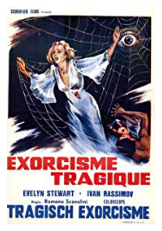

In [196]:
### YOUR CODE HERE
Q_idx = IDs[88]
print(f'Q_idx is {Q_idx}')
imshow(imread(Q_idx))

k = 5
rankID = k_nearest(imread(Q_idx),k)
print(f'rankID is {rankID}')


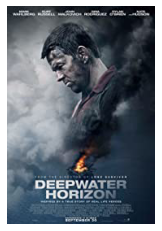

In [197]:
imshow(imread(IDs[rankID[0]]))

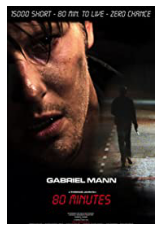

In [198]:
imshow(imread(IDs[rankID[1]]))

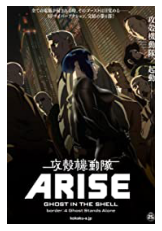

In [199]:
imshow(imread(IDs[rankID[2]]))

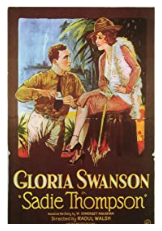

In [200]:
imshow(imread(IDs[rankID[3]]))

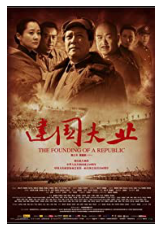

In [201]:
imshow(imread(IDs[rankID[4]]))

### Part 4: Year regression [5 marks]

Let's investigate the last question ("similar era") above by running **regression** on the year, ie attempt to predict the year, given the poster. Use a train-test split. Build a suitable Keras neural network model for this, **as a regression head on top of the embedding from Part 1**. Include comments to explain the purpose of each part of the model. It should be possible to make a prediction, given a new poster (not part of the original dataset). Write a short comment on model performance: is it possible to predict the year? Based on this result, are there trends over time?

In [202]:

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, years, test_size=0.2)

# Define the neural network model
customize_model = keras.Sequential([
    
    # Add a dense layer with ReLU activation
    layers.Dense(256, activation='relu'),
    # Add a dropout layer to reduce overfitting
    layers.Dropout(0.2),
    # Add another dense layer with ReLU activation
    layers.Dense(128, activation='relu'),
    # Add a dropout layer to reduce overfitting
    layers.Dropout(0.2),
    # Add a final dense layer with one output unit (year)
    layers.Dense(1, activation='relu')
    
])

# Compile the model with mean absolute error loss function and Adam optimizer
customize_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))


# Train the model on the training data
customize_history = customize_model.fit(X_train, y_train, epochs=10, validation_split=0.2)
                          

Epoch 1/10
25/25 [==============================] - 5s 127ms/step - loss: 1394.1664 - val_loss: 167.1659
Epoch 2/10
25/25 [==============================] - 2s 96ms/step - loss: 288.2370 - val_loss: 157.2231
Epoch 3/10
25/25 [==============================] - 2s 87ms/step - loss: 206.3967 - val_loss: 122.5989
Epoch 4/10
25/25 [==============================] - 3s 116ms/step - loss: 176.7248 - val_loss: 105.0221
Epoch 5/10
25/25 [==============================] - 3s 115ms/step - loss: 173.5576 - val_loss: 99.8267
Epoch 6/10
25/25 [==============================] - 3s 119ms/step - loss: 164.9422 - val_loss: 90.5492
Epoch 7/10
25/25 [==============================] - 3s 111ms/step - loss: 161.2787 - val_loss: 89.3456
Epoch 8/10
25/25 [==============================] - 3s 115ms/step - loss: 153.3917 - val_loss: 88.8296
Epoch 9/10
25/25 [==============================] - 3s 107ms/step - loss: 149.5644 - val_loss: 87.7676
Epoch 10/10
25/25 [==============================] - 3s 106ms/step - l

In [203]:
# Evaluate the model on the testing data
customize_model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 14ms/step - loss: 73.0325


73.0324935913086

In [204]:
y = 10
predictions = np.squeeze(customize_model.predict(X_test))[0:y].astype(int)
authentic = y_test[0:y].astype(int)

output = [(predictions[i], authentic[i]) for i in range(y)]
# Sort by true value from smallest to largest
sorted_output = sorted(output, key=lambda x: x[1]) 

for i in range(y):
    print("predict: {} authentic: {}".format(sorted_output[i][0], sorted_output[i][1]))


8/8 [==============================] - 0s 15ms/step
predict: 1775 authentic: 1933
predict: 1974 authentic: 1956
predict: 1887 authentic: 1968
predict: 1880 authentic: 1974
predict: 1787 authentic: 1989
predict: 1917 authentic: 1996
predict: 1892 authentic: 2001
predict: 1931 authentic: 2003
predict: 2067 authentic: 2008
predict: 2027 authentic: 2010


8/8 [==============================] - 0s 11ms/step


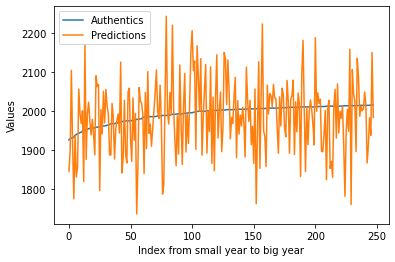

In [205]:
import matplotlib.pyplot as plt

y = 248
predictions = np.squeeze(customize_model.predict(X_test))[0:y].astype(int)
authentic = y_test[0:y].astype(int)


output = [(predictions[i], authentic[i]) for i in range(y)]
# Sort by true value from smallest to largest
sorted_output = sorted(output, key=lambda x: x[1]) 

x = range(y)

# Plot a line chart where the x-axis represents the time and the y-axis
# represents the true and predicted values
plt.plot(x, [x[1] for x in sorted_output], label='Authentics')
plt.plot(x, [x[0] for x in sorted_output], label='Predictions')

plt.xlabel('Index from small year to big year')
plt.ylabel('Values')
plt.legend()
plt.show()

# I can't observe any trend of the predictions over time.

### Part 5: Improvements [5 marks]

Propose a possible improvement. Some ideas are suggested below. The chosen improvement must be notified to the lecturer at least 1 week before submission and **must be approved by the lecturer to avoid duplication with other students**. Compare the performance between your original and your new model (the proposed improvement might not actually improve on model performance -- that is ok). Some marks will be awarded for more interesting / challenging / novel improvements.

Ideas:

* Try a different pretrained model for creating the embedding
* Alternative ways of reducing the pretrained model's output to a flat vector for the embedding
* Gather more data (see the csv file for URLs)
* Add different architectural details to the regression head
* Fine-tuning
* Training an end-to-end convnet of your own design (no pretraining)
* Improve the embedding by training a multi-headed model, eg predicting both genre and year
* Create a good visualisation of the embedding.


In [206]:
### YOUR CODE HERE

# change the architecture of the neural network model by adding more layers, 
# or changing the number of neurons in each layer,
# or using different activation functions to improve the model's performance. 

# Plan A:change the architecture of regression head 

# Define the neural network model
optimize_model = keras.Sequential([
    # layers.Dense(512, activation='linear'),
    # layers.Dense(1, activation='linear') 
    
    # Compare to part4 customize_model, I change the activation from 
    # 'relu' to 'linear'
    
    # Add a dense layer with ReLU activation
    layers.Dense(256, activation='linear'),
    # Add a dropout layer to reduce overfitting
    layers.Dropout(0.2),
    # Add another dense layer with ReLU activation
    layers.Dense(128, activation='linear'),
    # Add a dropout layer to reduce overfitting
    layers.Dropout(0.2),
    # Add a final dense layer with one output unit (year)
    layers.Dense(1, activation='linear')
])

# Compile the model with mean absolute error loss function and Adam optimizer
optimize_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))


# Train the model on the training data
optimize_history = optimize_model.fit(X_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
25/25 [==============================] - 5s 140ms/step - loss: 813.5410 - val_loss: 296.4079
Epoch 2/10
25/25 [==============================] - 3s 111ms/step - loss: 198.9241 - val_loss: 111.5445
Epoch 3/10
25/25 [==============================] - 2s 100ms/step - loss: 143.0235 - val_loss: 93.8850
Epoch 4/10
25/25 [==============================] - 2s 92ms/step - loss: 136.4202 - val_loss: 117.0531
Epoch 5/10
25/25 [==============================] - 2s 80ms/step - loss: 124.4982 - val_loss: 78.9383
Epoch 6/10
25/25 [==============================] - 2s 83ms/step - loss: 112.7994 - val_loss: 90.7035
Epoch 7/10
25/25 [==============================] - 2s 85ms/step - loss: 113.4815 - val_loss: 71.6550
Epoch 8/10
25/25 [==============================] - 3s 115ms/step - loss: 112.3952 - val_loss: 66.9458
Epoch 9/10
25/25 [==============================] - 2s 86ms/step - loss: 120.1840 - val_loss: 77.5014
Epoch 10/10
25/25 [==============================] - 3s 100ms/step - loss: 

In [207]:
# Evaluate the model on the testing data
optimize_model.evaluate(X_test, y_test)

8/8 [==============================] - 0s 8ms/step - loss: 73.1157


73.1156997680664

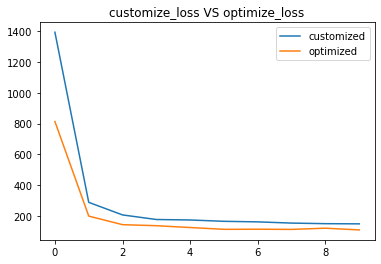

In [209]:
# Displays loss curves of the customize_model and optimize_model
customize_loss = customize_history.history['loss']
optimize_loss = optimize_history.history['loss']

plt.plot(customize_loss, label='customize_loss')
plt.plot(optimize_loss, label='optimize_loss')
plt.title('customize_loss VS optimize_loss')
plt.legend(['customized', 'optimized'])
plt.show()


In [210]:
# Plan B:change the architecture of vgg16 model
# let us observe the architecture of vgg16 model first

import torchvision
vgg16_false = torchvision.models.vgg16(pretrained=False)
print(vgg16_false)
conv_base.summary()
print(f'the number of vgg16 model layers is {len(conv_base.layers)}')

/Users/apple/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/apple/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [211]:
# I tried to change the vgg16 model by creating a vgg16 model and changing the architecture 
# be like  
# for layer in conv_base.layers[-13:]:
#     layer.trainable = True
# but failed
# So i decide to imitate vgg16 model and change some elements and parameters
# here is my code 


model2 = keras.Sequential()

# Optimize by increasing L2 regularization
model2.add(keras.layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(0.000)))
model2.add(keras.layers.Activation('relu'))

# Optimize by adding BN layer and dropout
model2.add(keras.layers.BatchNormalization())
model2.add(keras.layers.Dropout(0.3))

# original layers
model2.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model2.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model2.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model2.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))

model2.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model2.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2))

#Logout dense layers that we don't need
# model2.add(keras.layers.Flatten())
# model2.add(keras.layers.Dense(4096, activation='relu')) 
# model2.add(keras.layers.Dense(4096, activation='relu'))  
# model2.add(keras.layers.Dense(1000, activation='softmax'))  


In [213]:
#same as part1
model2.add(layers.Flatten())
# get the features and pass it to Z
features = model2.predict(img_array/255)
Z = features

assert len(Z.shape) == 2 # Z should be (n_movies, embedding_size)
assert Z.shape[0] == n_movies

39/39 [==============================] - 327s 8s/step


In [223]:
#same as part4, only the input changed from X to Z

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Z, years, test_size=0.2)

# Define the neural network model
optimize_model2 = keras.Sequential([
    
    # Add a dense layer with ReLU activation
    layers.Dense(256, activation='relu'),
    # Add a dropout layer to reduce overfitting
    layers.Dropout(0.2),
    # Add another dense layer with ReLU activation
    layers.Dense(128, activation='relu'),
    # Add a dropout layer to reduce overfitting
    layers.Dropout(0.2),
    # Add a final dense layer with one output unit (year)
    layers.Dense(1, activation='relu')
    
])

# Compile the model with mean absolute error loss function and Adam optimizer
optimize_model2.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001))


# Train the model on the training data
optimize_history2 = optimize_model2.fit(X_train, y_train, epochs=20, validation_split=0.2)                        

Epoch 1/20
25/25 [==============================] - 3s 83ms/step - loss: 1983.1891 - val_loss: 1957.9984
Epoch 2/20
25/25 [==============================] - 2s 75ms/step - loss: 1899.1384 - val_loss: 1790.2052
Epoch 3/20
25/25 [==============================] - 2s 71ms/step - loss: 1601.8038 - val_loss: 1302.7373
Epoch 4/20
25/25 [==============================] - 2s 83ms/step - loss: 881.2602 - val_loss: 301.2244
Epoch 5/20
25/25 [==============================] - 2s 74ms/step - loss: 335.2399 - val_loss: 251.9660
Epoch 6/20
25/25 [==============================] - 2s 69ms/step - loss: 308.2965 - val_loss: 243.3175
Epoch 7/20
25/25 [==============================] - 2s 68ms/step - loss: 306.3636 - val_loss: 241.5071
Epoch 8/20
25/25 [==============================] - 2s 69ms/step - loss: 313.5585 - val_loss: 238.3624
Epoch 9/20
25/25 [==============================] - 2s 69ms/step - loss: 302.5695 - val_loss: 234.8083
Epoch 10/20
25/25 [==============================] - 2s 68ms/step -

In [221]:
# Evaluate the model on the testing data
optimize_model2.evaluate(X_test, y_test)

8/8 [==============================] - 0s 10ms/step - loss: 255.7889


255.78892517089844

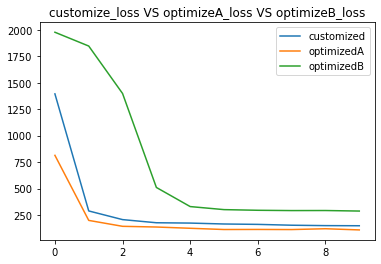

In [222]:
# Displays loss curves of the customize_model and optimize_model
customize_loss = customize_history.history['loss']
optimize1_loss = optimize_history.history['loss']
optimize2_loss = optimize_history2.history['loss']

plt.plot(customize_loss, label='customize_loss')
plt.plot(optimize1_loss, label='optimizeA_loss')
plt.plot(optimize2_loss, label='optimizeB_loss')
plt.title('customize_loss VS optimizeA_loss VS optimizeB_loss')
plt.legend(['customized', 'optimizedA','optimizedB'])
plt.show()